In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import StrMethodFormatter

# Global visualization style
sns.set_theme(style="whitegrid")

# File path
file_path = 'UK_HPI.xlsx'


In [8]:
# Load raw sheets once
df_type_raw = pd.read_excel(file_path, sheet_name='By type', na_values='-')
df_price_raw = pd.read_excel(file_path, sheet_name='Average price')
df_sales_raw = pd.read_excel(file_path, sheet_name='Sales Volume')


In [5]:
def clean_hpi_data(df, is_type_sheet=False):
    """
    Cleans UK HPI Excel sheets and returns tidy data.
    
    Parameters:
    - is_type_sheet: True for 'By type' sheet (Year/Month format),
                     False for borough-level sheets.
    """
    df = df.copy()
    df.columns = df.columns.str.strip()
    
    if is_type_sheet:
        # Build Date from Year and Month columns
        df['Date'] = pd.to_datetime(
            df['Year'].astype(str) + '-' +
            df['Month'].astype(str) + '-01'
        )
        return df.drop(columns=['Year', 'Month'])
    
    # Borough-level price / volume sheets
    df.rename(columns={df.columns[0]: 'Date'}, inplace=True)
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True, errors='coerce')
    
    return (
        df
        .melt(id_vars='Date', var_name='Borough', value_name='Value')
        .dropna(subset=['Date'])
    )


In [9]:
df_type = clean_hpi_data(df_type_raw, is_type_sheet=True)

df_price_long = (
    clean_hpi_data(df_price_raw)
    .rename(columns={'Value': 'Average_Price'})
)

df_sales_long = (
    clean_hpi_data(df_sales_raw)
    .rename(columns={'Value': 'Sales_Volume'})
)


In [10]:
# Merge price and volume data
df_london_combined = pd.merge(
    df_price_long,
    df_sales_long,
    on=['Date', 'Borough'],
    how='inner'
)

# Enforce numeric types and clean
df_london_combined[['Average_Price', 'Sales_Volume']] = (
    df_london_combined[['Average_Price', 'Sales_Volume']]
    .apply(pd.to_numeric, errors='coerce')
)

df_london_combined = (
    df_london_combined
    .dropna()
    .reset_index(drop=True)
)

df_london_combined.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16515 entries, 0 to 16514
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           16515 non-null  datetime64[ns]
 1   Borough        16515 non-null  object        
 2   Average_Price  16515 non-null  float64       
 3   Sales_Volume   16515 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 516.2+ KB


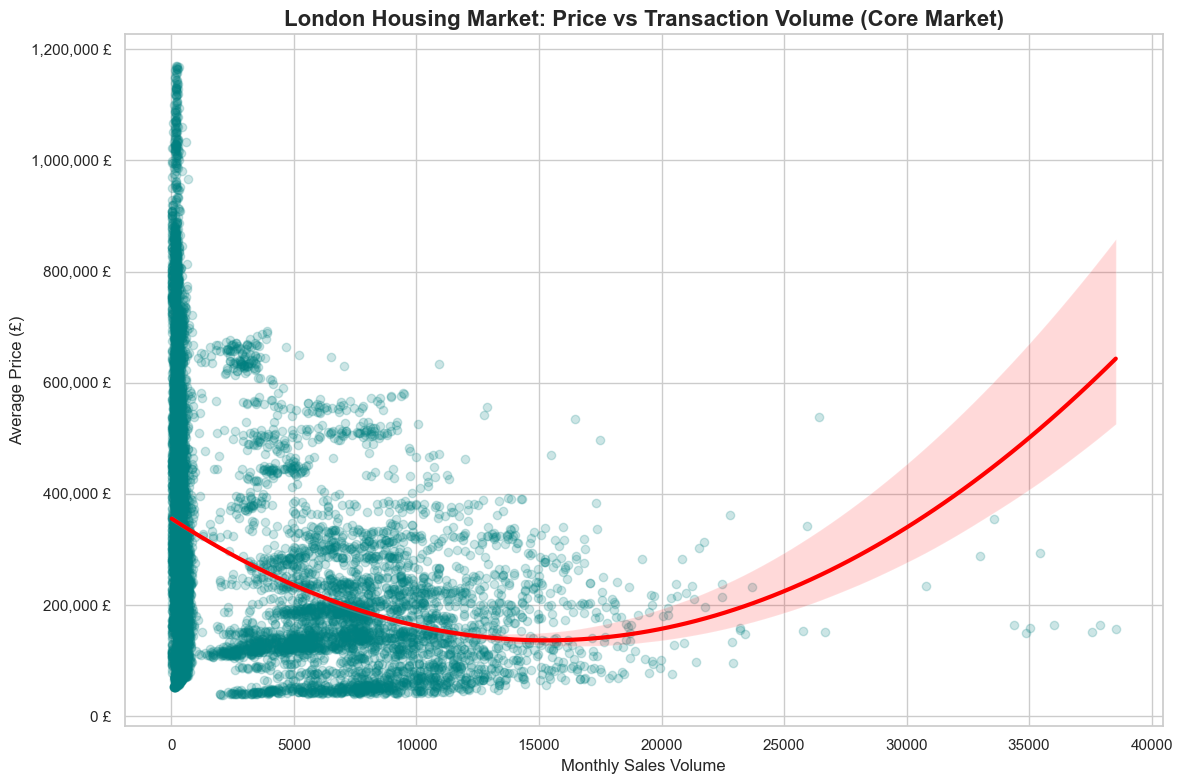

Global Correlation (r): -0.3041

Top 5 Boroughs by Volume–Price Sensitivity:
Borough
Tower Hamlets   -0.136887
NORTH EAST      -0.153159
Hillingdon      -0.174485
Greenwich       -0.177015
Hackney         -0.194875
Name: (Sales_Volume, Average_Price), dtype: float64


In [ ]:
# --------------------------------------------------------
# Price vs Transaction Volume Analysis
# --------------------------------------------------------

# Remove extreme aggregates (e.g. Greater London totals)
df_filtered = df_london_combined[
    df_london_combined['Sales_Volume'] < 40000
].copy()

# Global correlation
global_corr = (
    df_filtered[['Sales_Volume', 'Average_Price']]
    .corr()
    .iloc[0, 1]
)

# Borough-level correlations
borough_corr = (
    df_filtered
    .groupby('Borough')[['Sales_Volume', 'Average_Price']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .sort_values(ascending=False)
)

# Visualization
plt.figure(figsize=(12, 8))
sns.regplot(
    data=df_filtered,
    x='Sales_Volume',
    y='Average_Price',
    order=2,
    scatter_kws={'alpha': 0.2, 'color': 'teal'},
    line_kws={'color': 'red'}
)

plt.title(
    'London Real Estate: Price vs Transaction Volume Trend',
    fontsize=16,
    fontweight='bold'
)

plt.xlabel('Monthly Sales Volume')
plt.ylabel('Average Price (£)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f} £'))

plt.tight_layout()
plt.show()

print(f"Global Correlation (r): {global_corr:.4f}")
print("\nTop 5 Boroughs by Volume–Price Sensitivity:")
print(borough_corr.head(5))


The initial peak in the regplot reflects high average prices occurring at relatively low transaction volumes.
This is typical of premium market segments, where high-value properties are traded infrequently.
As transaction volume increases, the market composition shifts towards more accessible properties, which naturally lowers the overall average price.
I used a second-order regression to capture this non-linear behaviour, as a linear model would be misleading.
The analysis is descriptive and aimed at understanding market structure rather than inferring causality.

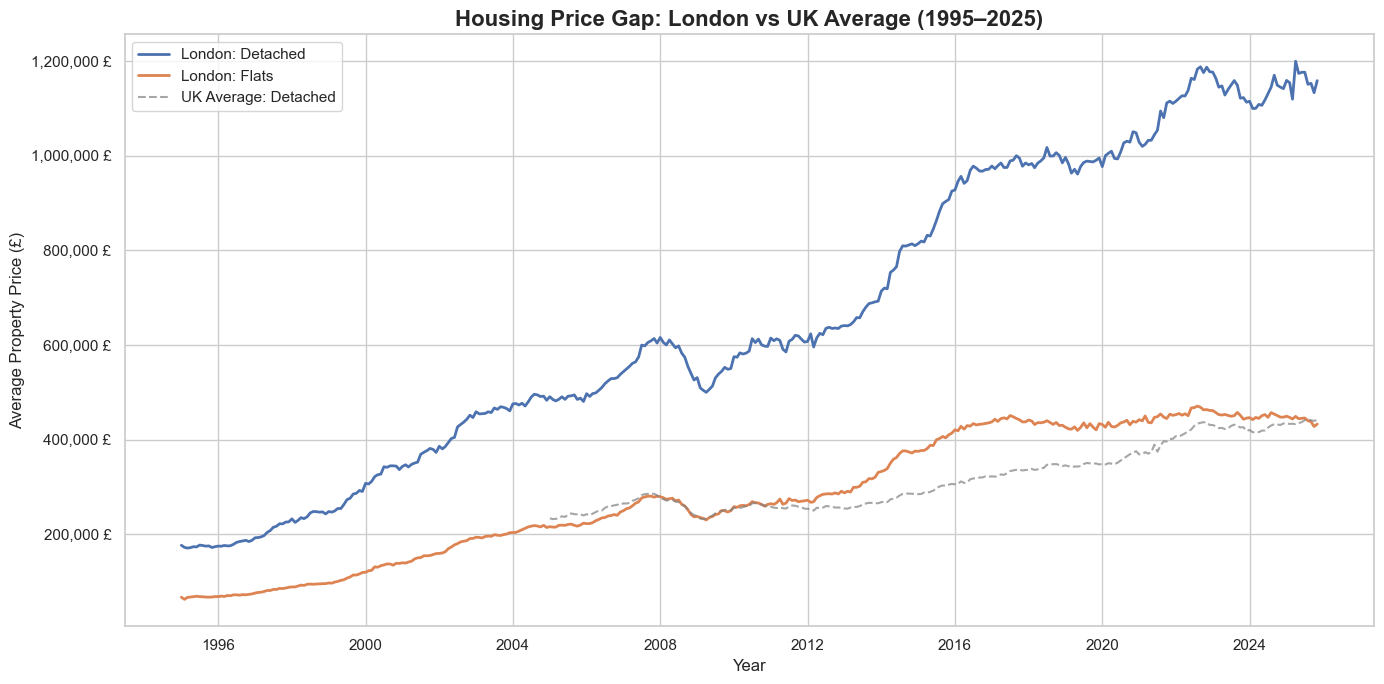

In [12]:
# --------------------------------------------------------
# London vs UK Housing Price Comparison
# --------------------------------------------------------

plt.figure(figsize=(14, 7))

sns.lineplot(
    data=df_type,
    x='Date',
    y='London_Price_Detached',
    label='London: Detached',
    linewidth=2
)

sns.lineplot(
    data=df_type,
    x='Date',
    y='London_Price_Flat',
    label='London: Flats',
    linewidth=2
)

sns.lineplot(
    data=df_type,
    x='Date',
    y='UK_Price_Detached',
    label='UK Average: Detached',
    linestyle='--',
    color='gray',
    alpha=0.7
)

plt.title(
    'Housing Price Gap: London vs UK Average (1995–2025)',
    fontsize=16,
    fontweight='bold'
)

plt.xlabel('Year')
plt.ylabel('Average Property Price (£)')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f} £'))

plt.legend(frameon=True)
plt.tight_layout()
plt.show()


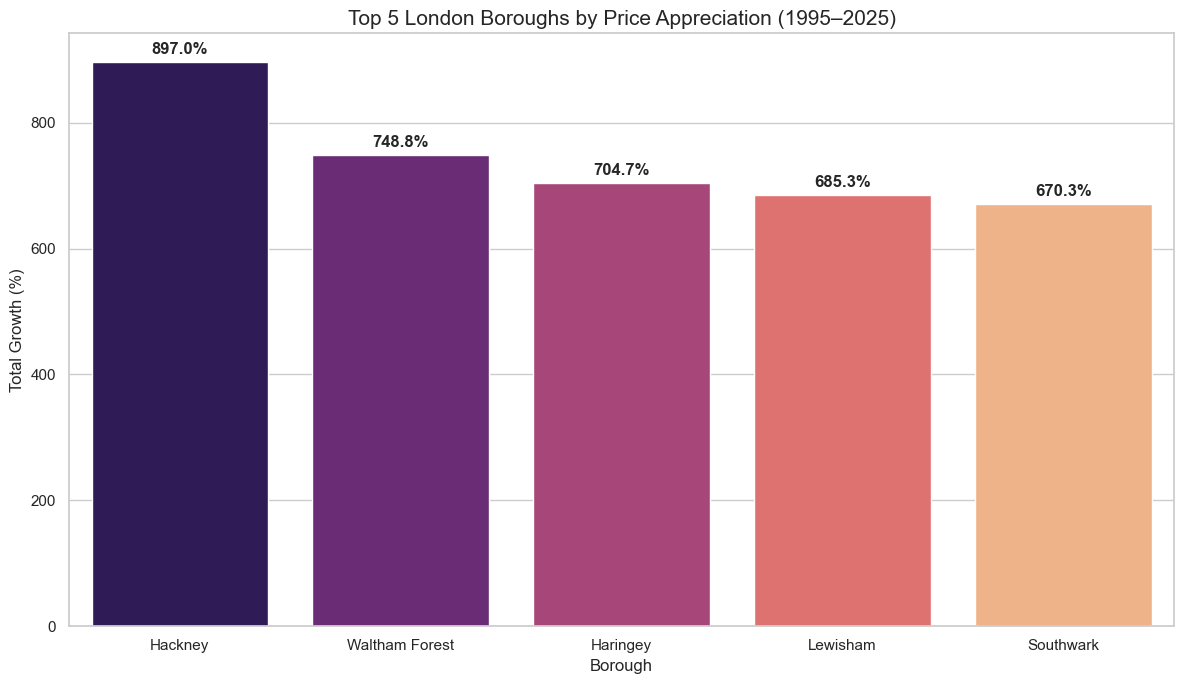

In [13]:
# --------------------------------------------------------
# Borough-Level Price Appreciation
# --------------------------------------------------------

# Identify analysis window
earliest = df_london_combined['Date'].min()
latest = df_london_combined['Date'].max()

# Extract start and end prices
df_perf = df_london_combined[
    df_london_combined['Date'].isin([earliest, latest])
]

df_perf = (
    df_perf
    .pivot(index='Borough', columns='Date', values='Average_Price')
    .reset_index()
)

df_perf.columns = ['Borough', 'Price_Start', 'Price_End']

# Remove invalid start prices
df_perf = df_perf[df_perf['Price_Start'] > 0]

# Percentage growth
df_perf['Pct_Change'] = (
    (df_perf['Price_End'] - df_perf['Price_Start'])
    / df_perf['Price_Start']
) * 100

top_5 = (
    df_perf
    .sort_values(by='Pct_Change', ascending=False)
    .head(5)
)

# Visualization
plt.figure(figsize=(12, 7))
ax = sns.barplot(
    data=top_5,
    x='Borough',
    y='Pct_Change',
    hue='Borough',
    palette='magma',
    legend=False
)

for p in ax.patches:
    ax.annotate(
        f'{p.get_height():.1f}%',
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 9),
        textcoords='offset points',
        fontweight='bold'
    )

plt.title(
    f'Top 5 London Boroughs by Price Appreciation ({earliest.year}–{latest.year})',
    fontsize=15
)

plt.ylabel('Total Growth (%)')
plt.tight_layout()
plt.show()
